In [1]:
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from PIL import Image
from torchvision.transforms import functional as TF
from matplotlib import cm
from sklearn.model_selection import train_test_split


In [2]:
SEED = 0

In [3]:
def read_gz_files(dir, x_file, y_file, image_size, num_images):

    with gzip.open(os.path.join(dir, x_file),'rb') as f:
        f.read(16)
        buf = f.read(image_size * image_size * num_images)
        images = np.copy(np.frombuffer(buf, dtype=np.uint8))
        images = images.reshape(num_images, image_size, image_size)

    with gzip.open(os.path.join(dir, y_file),'rb') as f:
        f.read(8)
        buf = f.read(num_images)
        labels = np.copy(np.frombuffer(buf, dtype=np.uint8))
    
    return images, labels


In [4]:
dir = f'data/MNIST'
train_x_file = 'train-images-idx3-ubyte.gz'
train_y_file = 'train-labels-idx1-ubyte.gz'
test_x_file = 't10k-images-idx3-ubyte.gz'
test_y_file = 't10k-labels-idx1-ubyte.gz'



In [5]:
image_size = 28
np.random.seed(0)

train_images, train_labels = read_gz_files(dir, train_x_file, train_y_file, image_size, num_images=60000)
test_images, test_labels = read_gz_files(dir, test_x_file, test_y_file, image_size, num_images=10000)

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
# Choose a color map from matplotlib (e.g., 'tab10' or 'viridis')
colormap = cm.get_cmap('summer', 40)  # 'tab10' has distinct colors for 10 categories

# Create a mapping of digits to colors using the colormap
digit_to_color = {i: colormap(i)[:3] for i in range(10)} # above cmap assigned to each digit
digit_to_unicolor = {i: (0.26, 0.63, 0.4) for i in range(10)} # green
# digit_to_unicolor = {i: (0.07692307692307693, 0.5384615384615384, 0.4) for i in range(10)}
# digit_to_unicolor2 = {i: (1, 1, 1) for i in range(10)} # white
digit_to_unicolor2 = {i: (149/255, 52/255, 235/255) for i in range(10)} # purple

# digit_to_unicolor = {i: (0.15, 0.52, 0.56) for i in range(10)}

digit_to_color_rev = {i: colormap(9-i)[:3] for i in range(10)}

/tmp/ipykernel_2615255/3063259499.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('summer', 40)  # 'tab10' has distinct colors for 10 categories


In [8]:
digit_to_color

{0: (0.0, 0.5, 0.4),
 1: (0.02564102564102564, 0.5128205128205128, 0.4),
 2: (0.05128205128205128, 0.5256410256410257, 0.4),
 3: (0.07692307692307693, 0.5384615384615384, 0.4),
 4: (0.10256410256410256, 0.5512820512820513, 0.4),
 5: (0.1282051282051282, 0.5641025641025641, 0.4),
 6: (0.15384615384615385, 0.5769230769230769, 0.4),
 7: (0.1794871794871795, 0.5897435897435898, 0.4),
 8: (0.20512820512820512, 0.6025641025641025, 0.4),
 9: (0.23076923076923078, 0.6153846153846154, 0.4)}

In [9]:
digit_to_color_rev

{0: (0.23076923076923078, 0.6153846153846154, 0.4),
 1: (0.20512820512820512, 0.6025641025641025, 0.4),
 2: (0.1794871794871795, 0.5897435897435898, 0.4),
 3: (0.15384615384615385, 0.5769230769230769, 0.4),
 4: (0.1282051282051282, 0.5641025641025641, 0.4),
 5: (0.10256410256410256, 0.5512820512820513, 0.4),
 6: (0.07692307692307693, 0.5384615384615384, 0.4),
 7: (0.05128205128205128, 0.5256410256410257, 0.4),
 8: (0.02564102564102564, 0.5128205128205128, 0.4),
 9: (0.0, 0.5, 0.4)}

In [10]:
def colorise(grayscale_images, labels, digit_to_color_map, color):
    num_images, height, width = grayscale_images.shape
    colored_images = np.zeros((num_images, height, width, 3))

    # Normalize grayscale images to [0, 1] range
    normalized_images = grayscale_images / 255.0

    # Apply the color mapping for each image
    if color:
        for i in range(num_images):
            color = digit_to_color_map[labels[i]]
            colored_images[i] = normalized_images[i, ..., np.newaxis] * np.array(color) * 255.
    else:
        colored_images = np.stack((normalized_images,)*3, axis=-1) * 255.
    
    colored_images = colored_images.astype(np.uint8)

    return colored_images

In [11]:
def balance(images, labels):
    uniques, counts = np.unique(labels, return_counts=True)
    min_count = min(counts)

    out_imgs = []
    out_lbls = []
    for label in uniques:
        imgs = images[np.where(labels == label)]
        imgs = imgs[:min_count]
        lbls = labels[np.where(labels == label)]
        lbls = lbls[:min_count]
        out_imgs.append(imgs)
        out_lbls.append(lbls)
    out_imgs = np.concatenate(out_imgs, axis=0)
    out_lbls = np.concatenate(out_lbls, axis=0)
    indices = np.random.permutation(len(out_imgs))
    return out_imgs[indices], out_lbls[indices]

In [12]:
def split_balanced(images, labels, n_splits=10):
    # Find unique labels
    unique_labels = np.unique(labels)
    
    # Initialize empty lists to hold the splits
    split_images = [[] for _ in range(n_splits)]
    split_labels = [[] for _ in range(n_splits)]
    
    # For each label, split the images into `n_splits` equal parts
    for label in unique_labels:
        # Get images corresponding to the current label
        label_images = images[labels == label]
        np.random.shuffle(label_images) # shuffle the images for randomness

        # Determine the number of images per split for this label
        split_size = len(label_images) // n_splits
        
        # Split the label's images into `n_splits` parts
        for i in range(n_splits):
            start_idx = i * split_size
            end_idx = (i + 1) * split_size if i < n_splits - 1 else len(label_images)
            split_images[i].append(label_images[start_idx:end_idx])
            split_labels[i].append(np.full(end_idx - start_idx, label))

    # Convert lists of arrays into numpy arrays and shuffle each subset
    for i in range(n_splits):
        split_images[i] = np.concatenate(split_images[i], axis=0)
        split_labels[i] = np.concatenate(split_labels[i], axis=0)
        
        # Shuffle the images and labels together
        indices = np.random.permutation(len(split_images[i]))
        split_images[i] = split_images[i][indices]
        split_labels[i] = split_labels[i][indices]
        
    return split_images, split_labels

In [13]:
def save_data(images, labels, dir, name, split, center):

    save_as = f"{name.lower()}_{split}_{center}.npz"
    np.savez(os.path.join(dir, save_as), 
                images=images,
                labels=labels)



In [14]:
def shuffle(images, labels):
    n_samples = len(labels)
    shuffled_indices = np.random.permutation(n_samples)

    labels = labels[shuffled_indices]
    images = images[shuffled_indices]

    return images, labels

def sample(ratio, images, labels):
    n_samples = len(labels)
    shuffled_indices = np.random.permutation(n_samples)
    n_sub = int(ratio * n_samples)
    shuffled_indices = shuffled_indices[:n_sub]

    labels = labels[shuffled_indices]
    images = images[shuffled_indices]

    return images, labels


In [15]:
dest_dir = 'data/MNIST/cmnist3x10c_clean'
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
else:
    print("Warning, existing files might be overwritten")
maps = [digit_to_unicolor, digit_to_color, digit_to_unicolor2]
color_groups = [False, True, False]
centers_per_group = [10, 10, 10]  # Different numbers of centers for each group
subsample_per_group = [0.5, 1, 0.5]

# Total number of centers is the sum of centers_per_group
num_centers = sum(centers_per_group)

train_images, train_labels = balance(train_images, train_labels)
print(train_images.shape)
print(train_labels.shape)
test_images, test_labels = balance(test_images, test_labels)

shuffled_trains = [(shuffle(train_images, train_labels)) for _ in range(len(color_groups))]
shuffled_tests = [(shuffle(test_images, test_labels)) for _ in range(len(color_groups))]

# with the split train and test, apply rotation to each split
val_split = 0.1

for i, (color_group, centers, subsample_group) in enumerate(zip(color_groups, centers_per_group, subsample_per_group)):
    print(i)
    train_images, train_labels = shuffled_trains[i]
    test_images, test_labels = shuffled_tests[i]
    split_train_images, split_train_labels = split_balanced(train_images, train_labels, centers)
    split_test_images, split_test_labels = split_balanced(test_images, test_labels, centers)

    for j in range(centers):
        center_train_images = colorise(split_train_images[j], split_train_labels[j], digit_to_color_map=maps[i], color=True)
        center_train_labels = split_train_labels[j]

        X_train, X_val, y_train, y_val = train_test_split(center_train_images, center_train_labels, test_size=val_split, random_state=SEED)
        X_train, y_train = sample(subsample_group, X_train, y_train)
        center_num = sum(centers_per_group[:i]) + j  # Compute center index globally
        
        save_data(X_train, y_train, dest_dir, "cmnist", "train", center_num)
        save_data(X_val, y_val, dest_dir, "cmnist", "val", center_num)

        # poison
        # center_test_images = colorise(split_test_images[j], split_test_labels[j], digit_to_color_map=digit_to_color_rev, color=True)
        
        # train == test 
        center_test_images = colorise(split_test_images[j], split_test_labels[j], digit_to_color_map=maps[i], color=True)

        center_test_labels = split_test_labels[j]
        save_data(center_test_images, center_test_labels, dest_dir, "cmnist", "test", center_num)
        print("center:", center_num, "train", len(y_train), "val", len(y_val), "test", len(center_test_labels))


(54210, 28, 28)
(54210,)
0
center: 0 train 2439 val 542 test 890
center: 1 train 2439 val 542 test 890
center: 2 train 2439 val 542 test 890
center: 3 train 2439 val 542 test 890
center: 4 train 2439 val 542 test 890
center: 5 train 2439 val 542 test 890
center: 6 train 2439 val 542 test 890
center: 7 train 2439 val 542 test 890
center: 8 train 2439 val 542 test 890
center: 9 train 2443 val 543 test 910
1
center: 10 train 4878 val 542 test 890
center: 11 train 4878 val 542 test 890
center: 12 train 4878 val 542 test 890
center: 13 train 4878 val 542 test 890
center: 14 train 4878 val 542 test 890
center: 15 train 4878 val 542 test 890
center: 16 train 4878 val 542 test 890
center: 17 train 4878 val 542 test 890
center: 18 train 4878 val 542 test 890
center: 19 train 4887 val 543 test 910
2
center: 20 train 2439 val 542 test 890
center: 21 train 2439 val 542 test 890
center: 22 train 2439 val 542 test 890
center: 23 train 2439 val 542 test 890
center: 24 train 2439 val 542 test 890
cent

In [16]:
# duplicated_rot_groups = [group for group in color_groups for _ in range(centers_per_group)]

# log = [rot for rot in duplicated_rot_groups]
# with open(os.path.join(dest_dir, "log.txt"), "w") as f:
#     f.write(str(log))

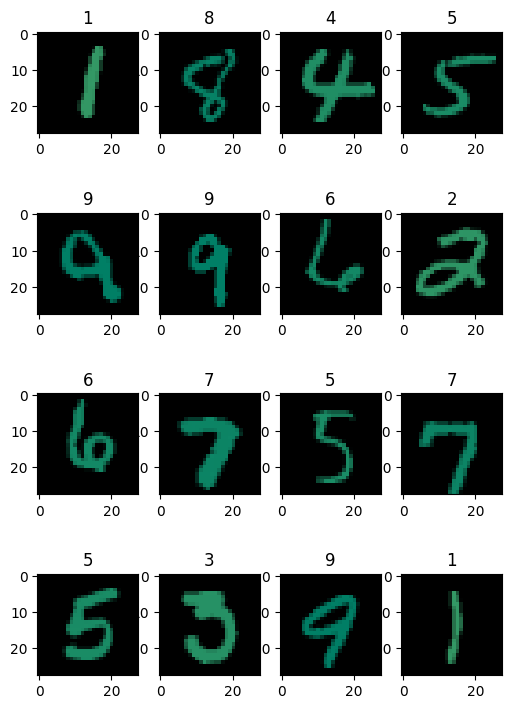

In [20]:
imgs = np.load('data/MNIST/cmnist3x10c/cmnist_test_6.npz')['images']
lbls = np.load('data/MNIST/cmnist3x10c/cmnist_test_6.npz')['labels']
fig, ax = plt.subplots(4, 4, figsize=(6,9))

for idx in range(16):
    row = idx // 4
    col = idx % 4
    ax[row][col].imshow(imgs[idx])
    ax[row][col].set_title(lbls[idx])